<a href="https://colab.research.google.com/github/lamyeamaha/tensorflow-codes/blob/main/Tensorflow_transfer_learning_on_cat_dog_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pre-trained models - it is a saved network that is already trianed on a large dataset.

You can use a pre-trained model as it is. Or, use transfer learning to customize the pre-trained models

idea behind transfer learnng - since the model is trained on large dataset, the model will be generic. you can use the learned feature maps in your project without having to do it from scratch


Key points to note:
1. image_dataset_from_directory - function to create dataset from image files
2. shuffle = True - ensures the images in each batch are shuffled - ensures the model does not memorize the data, but learns the underlying patterns
3. batch_size - the number of images in each batch used during training
4.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

**Download dataset**

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

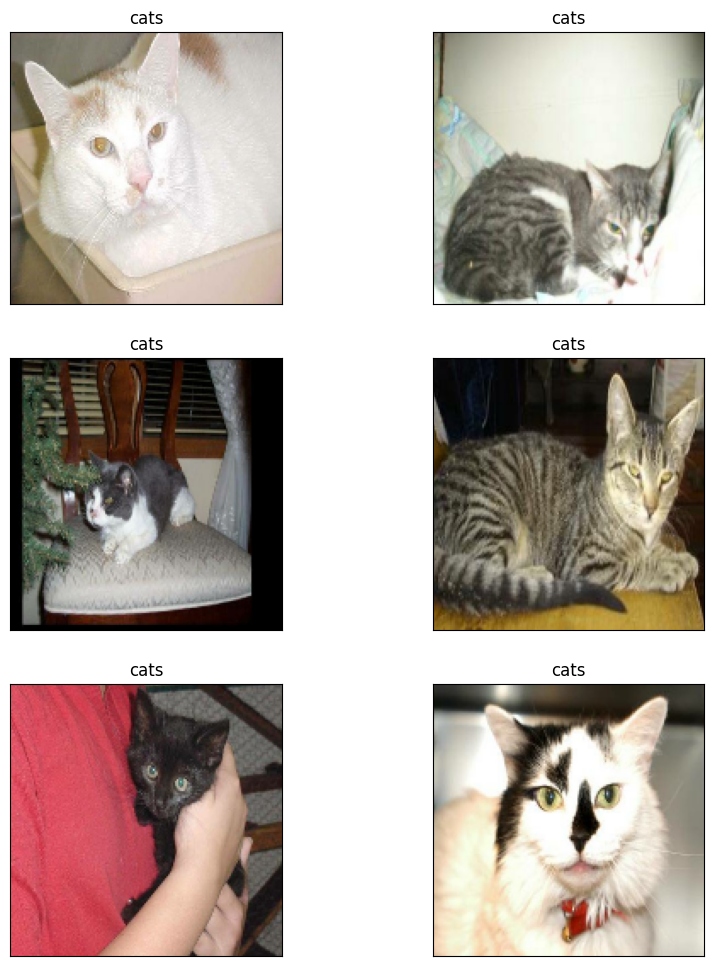

In [ ]:
for (images,labels) in train_dataset.take(1):
  plt.figure(figsize=(10,12))
  for i in range(6):
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])



**Creating a test set**
- the dataset does not explicitly have a test dataset.
so move 20% of the data from validation dataset to a newly created test dataset

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('val batches: ',val_batches.numpy().astype("uint8"))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

val batches:  32
Number of validation batches: 26
Number of test batches: 6


**Increase data performance**
- Use buffered prefetching to load images from disk without having I/O become blocking.
- The prefetch method is commonly used in deep learning pipelines, especially with large datasets, to improve training performance by *overlapping data loading and model training.*

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Data augmentation**
- reduces overfitting
- used when you have a small dataset

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

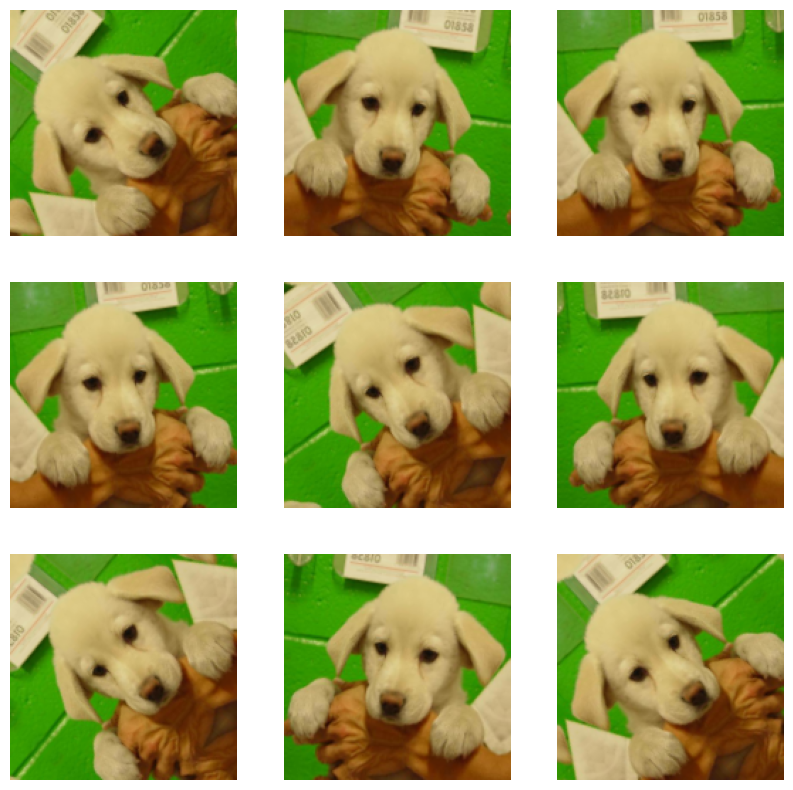

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

**Rescale according to the model you are going to use**

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Base model**
- include_top  = false --> you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:
# you are applying this to just one batch. you do not need to do this.
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)   # output: (batch_size, height, width, num_of_channels)


(32, 5, 5, 1280)


**Freeze the convolutional base**
- It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

**Check the model's architecture**

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

**Add a global average pooling layer**
- It's often used as a way to reduce the spatial dimensions of the feature maps generated by the convolutional layers before connecting to fully connected (dense) layers for classification.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# analyze to see what it does to a single batch:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


**Add a dense layer**

In [ ]:
prediction_layer = tf.keras.layers.Dense(1) # a dense layer with one neurone

# analyze to see what it does to a single batch:
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**Chain all these together**

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

**Trainable variables: weights and biases**

In [ ]:
len(model.trainable_variables)

2

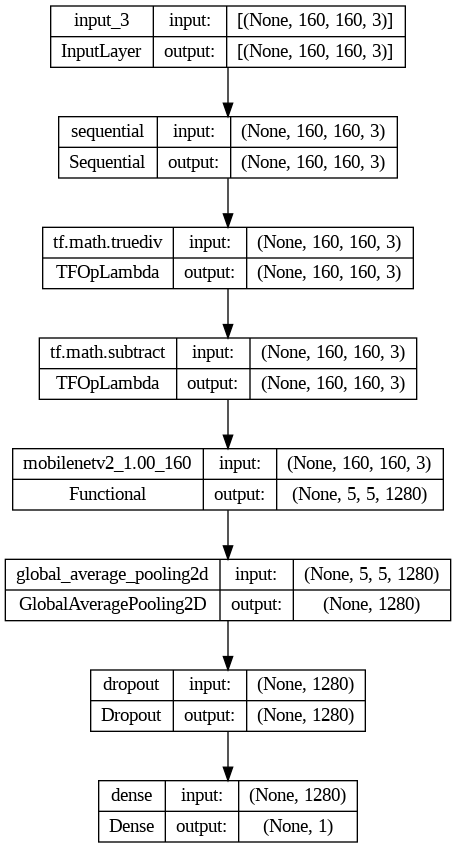

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Compile the model**

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

**Train the model**

In [ ]:
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=validation_dataset)

Epoch 1/2
63/63 [==============================] - 40s 558ms/step - loss: 0.8001 - accuracy: 0.5185 - val_loss: 0.6204 - val_accuracy: 0.6646
Epoch 2/2
63/63 [==============================] - 34s 546ms/step - loss: 0.5951 - accuracy: 0.6875 - val_loss: 0.4567 - val_accuracy: 0.8131


In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
#these values are changing each time i run the above line of code possibley dute to the way tensorflow use GPU
print(loss)
print(accuracy)

26/26 [==============================] - 9s 351ms/step - loss: 0.4461 - accuracy: 0.8193
0.44608137011528015
0.8193069100379944


**Learning curves:  validation and training**

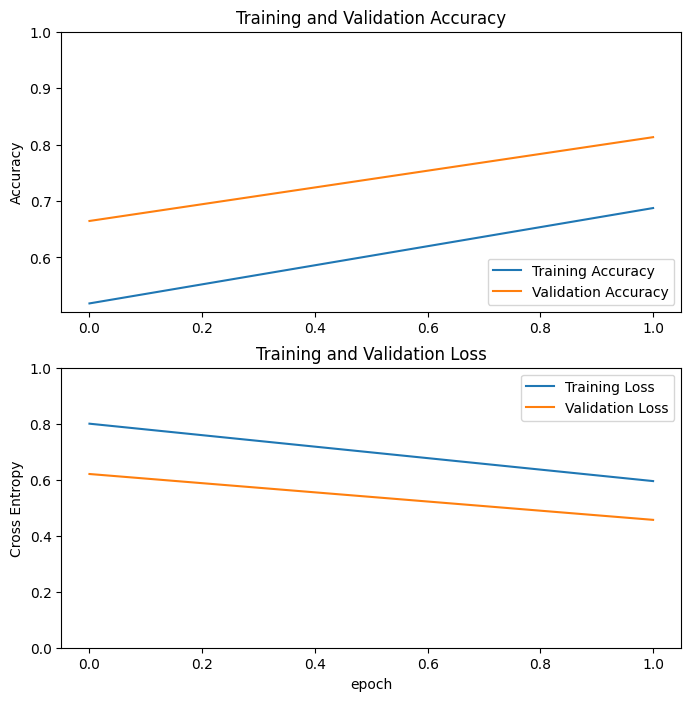

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tune the model**